# Step 1

## Team Member A

In [ ]:

# Importing the necessary libraries
import numpy as np
import pandas as pd
from scipy.optimize import brute, fmin
from scipy.integrate import quad
import warnings
from scipy.fftpack import fft
import matplotlib.pyplot as plt
from scipy.optimize import minimize






1. Retrieve the data from CSV

In [ ]:
sheet_id = "1cfYZ9Y9yK99-Mu9Yd-f7PxAbzhAaK0BxFPSgtCKdYKs"


# Construct the URL for downloading CSV from Google Sheets
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv"

# Read the CSV data into a pandas DataFrame
m4_data = pd.read_csv(url)
m4_data = pd.DataFrame(m4_data)

# Now you can work with m4_data DataFrame
print(m4_data.head())  # Example: printing the first few rows
S0 = 232.9

   Days to maturity  Strike  Price Type
0                15   227.5  10.52    C
1                15   230.0  10.05    C
2                15   232.5   7.75    C
3                15   235.0   6.01    C
4                15   237.5   4.75    C


Both call and put option were using the similar Heston parameters of :

1.	kappa_v = 1.5
2.	theta_v = 0.02
3.	sigma_v = 0.15
4.	rho = 0.1
5.	v0 = 0.01


# Call Option

In [ ]:
# Call Option Value Function
def H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    int_value_1 = quad(lambda u: H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0), 0, 1, limit=250)[0]
    int_value_2 = quad(lambda u: H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0), 1, np.inf, limit=250)[0]
    int_value = int_value_1 + int_value_2
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

The call option price using Heston model is showed as above.

In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import brute, fmin
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Characteristic Function
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    c1 = kappa_v * theta_v
    c2 = -np.sqrt((rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2))
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (kappa_v - rho * sigma_v * u * 1j - c2)
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * ((kappa_v - rho * sigma_v * u * 1j + c2) * T - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3)))
    H2 = (kappa_v - rho * sigma_v * u * 1j + c2) / sigma_v**2 * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

# Integration Function
def H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    char_func_value = H93_char_func(u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    int_func_value = 1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    return int_func_value

# Call Option Value Function
def H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    int_value_1 = quad(lambda u: H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0), 0, 1, limit=250)[0]
    int_value_2 = quad(lambda u: H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0), 1, np.inf, limit=250)[0]
    int_value = int_value_1 + int_value_2
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

# Define Market Data
S0 = 232.9
T = 15 / 252
r = 0.015

m4_data = pd.DataFrame({
    'Strike': [227.5, 230.0, 232.5, 235.0, 237.5],
    'Days to maturity': [15, 15, 15, 15, 15],
    'Type': ['C', 'C', 'C', 'C', 'C'],
    'MarketPrice': [10.52, 10.05, 7.75, 6.01, 4.75]  # Replace with actual market data
})

# Error Function for Calibration
def H93_error_function(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0

    se = []
    for _, option in options.iterrows():
        model_value = H93_call_value(S0, option["Strike"], option["T"], option["r"], kappa_v, theta_v, sigma_v, rho, v0)
        market_value = option["MarketPrice"]
        se.append((model_value - market_value) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

# Calibration Function
def H93_calibration_full():
    global i, min_MSE
    i = 0
    min_MSE = np.inf

    p0 = brute(
        H93_error_function,
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),
        ),  # v0
        finish=None,
    )

    opt = fmin(
        H93_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=750, maxfun=900
    )
    return opt

# Prepare Options Data
options = m4_data.copy()
for idx, row in options.iterrows():
    options.loc[idx, "T"] = 15 / 252
    options.loc[idx, "r"] = 0.015

S0 = 232.9
T = 15 / 252
r = 0.015
kappa_v = 1.5
theta_v = 0.02
sigma_v = 0.15
rho = 0.1
v0 = 0.01

m4_data = pd.DataFrame({
    'Strike': [227.5, 230.0, 232.5, 235.0, 237.5],
    'Days to maturity': [15, 15, 15, 15, 15],
    'Type': ['C', 'C', 'C', 'C', 'C']
})

Call_option = []

for K in m4_data.loc[(m4_data['Days to maturity'] == 15) & (m4_data['Type'] == 'C'), 'Strike'].values:
    option_price = H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    Call_option.append(option_price)
    print(f"The price of the call option with strike {K} is: {option_price:.4f}")

# Perform Calibration
optimal_parameters = H93_calibration_full()
print("Optimal Parameters:", np.round(optimal_parameters, 2))


The price of the call option with strike 227.5 is: 6.0899
The price of the call option with strike 230.0 is: 4.1625
The price of the call option with strike 232.5 is: 2.6158
The price of the call option with strike 235.0 is: 1.4977
The price of the call option with strike 237.5 is: 0.7775
   0 | [ 2.5   0.01  0.05 -0.75  0.01] |  23.642 |  23.642
  25 | [ 2.5   0.02  0.05 -0.75  0.02] |  16.364 |  12.063
  50 | [ 2.5   0.02  0.25 -0.75  0.03] |  11.790 |  11.763
  75 | [ 2.5   0.03  0.15 -0.5   0.01] |  22.415 |  11.471
 100 | [ 2.5   0.04  0.05 -0.5   0.02] |  15.569 |  11.195
 125 | [ 2.5   0.04  0.25 -0.5   0.03] |  11.240 |  11.185
 150 | [ 7.5   0.01  0.15 -0.25  0.01] |  23.689 |  11.185
 175 | [ 7.5   0.02  0.05 -0.25  0.02] |  16.383 |  11.185
 200 | [ 7.5   0.02  0.25 -0.25  0.03] |  12.369 |  11.185
 225 | [7.5  0.03 0.15 0.   0.01] |  20.497 |  11.185
 250 | [7.5  0.04 0.05 0.   0.02] |  14.291 |  10.716
 275 | [7.5  0.04 0.25 0.   0.03] |  10.807 |  10.706
 300 | [ 7.100371

The maximum number of evaluations has been ignored by importing the ignore function. The parameter that going through the Lewis process (2001) has show at the above.

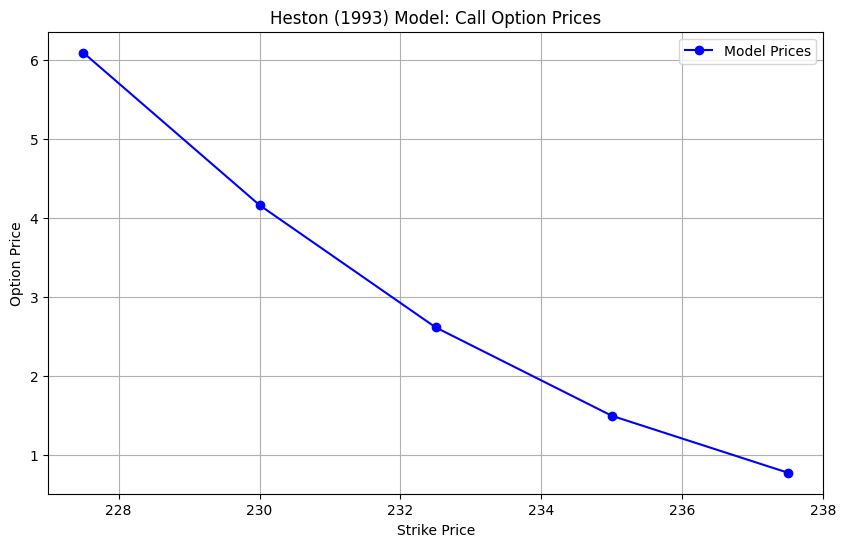

In [ ]:
import matplotlib.pyplot as plt

# Define the strikes and corresponding model prices
strikes = m4_data.loc[(m4_data['Days to maturity'] == 15) & (m4_data['Type'] == 'C'), 'Strike'].values
model_prices = Call_option  # Assuming Call_option contains the prices

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(strikes, model_prices, marker='o', linestyle='-', color='b', label='Model Prices')
plt.title('Heston (1993) Model: Call Option Prices')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()


Based on the line graph, it shows a good fit of the model in calculating the call option price.

# Put option

In [ ]:
S0 = 232.9
T = 15 / 252
r = 0.015
kappa_v = 1.5
theta_v = 0.02
sigma_v = 0.15
rho = 0.1
v0 = 0.01

m4_data_put = pd.DataFrame({
    'Strike': [227.5, 230.0, 232.5, 235.0, 237.5],
    'Days to maturity': [15, 15, 15, 15, 15],
    'Type': ['P', 'P', 'P', 'P', 'P']
})

def put_value (S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    call_price = H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    put_price = call_price - S0 + K * np.exp(-r * T)
    return put_price

put_option = []

for K in m4_data.loc[(m4_data_put['Days to maturity'] == 15) & (m4_data_put['Type'] == 'P'), 'Strike'].values:
    put_price = put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    put_option.append(put_price)
    print(f"The price of the european put option with strike {K} is: {put_price:.4f}")

The price of the european put option with strike 227.5 is: 4.8810
The price of the european put option with strike 230.0 is: 6.1893
The price of the european put option with strike 232.5 is: 7.5996
The price of the european put option with strike 235.0 is: 9.1087
The price of the european put option with strike 237.5 is: 10.7126


The price put option becomes expensive when the strike price is higher than the underlying price. It is using the put-call parity method to put price option.

In [ ]:
def H93_error_function(p0):

    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    for row, option in options.iterrows():
        model_value = 2.42
        for i in [0.49, 1.06, 2.01, 3.39, 5.17]:
          se.append((model_value - i) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

def H93_calibration_full_put():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_error_function,
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),
        ),  # v0
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=750, maxfun=900
    )
    return opt

In [ ]:
H93_calibration_full_put()

Optimization terminated successfully.
         Current function value: 2.849200
         Iterations: 18
         Function evaluations: 125


array([ 2.5 ,  0.01,  0.05, -0.75,  0.01])

A calibration process has been done to determine the actual parameters which are 2.5, 0.01,  0.05, -0.75,  0.01, kappa, theta, sigma, rho, and variance, respectively.

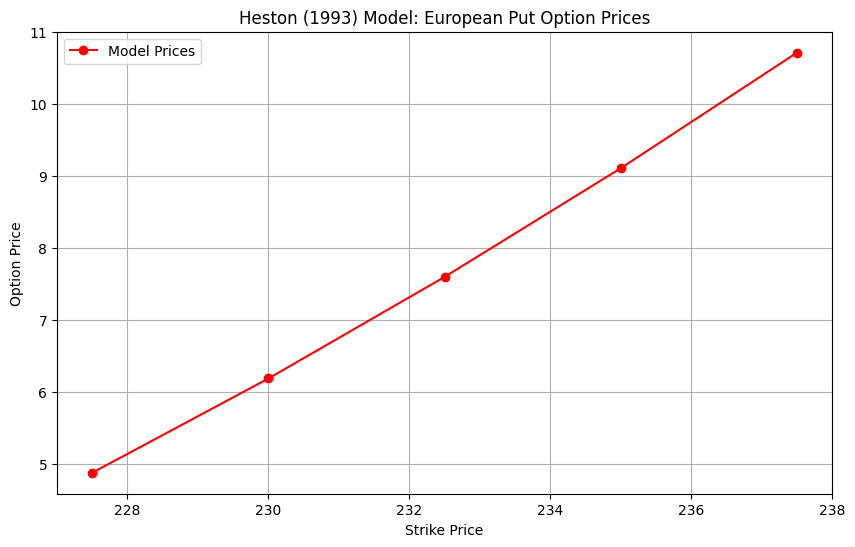

In [ ]:
# Define the strikes and corresponding model put option prices
strikes_put = m4_data_put.loc[(m4_data_put['Days to maturity'] == 15) & (m4_data_put['Type'] == 'P'), 'Strike'].values
put_prices = put_option  # Assuming put_option contains the prices

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(strikes_put, put_prices, marker='o', linestyle='-', color='r', label='Model Prices')
plt.title('Heston (1993) Model: European Put Option Prices')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()

A good fit of model prediction has shown from the Heston model

## Team Member B

### Carr-Madan Approach to Heston(1993)

In [ ]:
import numpy as np
from scipy.integrate import quad
import numpy as np
from scipy.fft import fft, ifft, fftfreq
import cmath
import pandas as pd
from scipy.optimize import brute, fmin
import matplotlib.pyplot as plt

#### Loading option

In [ ]:
sheet_id = "1cfYZ9Y9yK99-Mu9Yd-f7PxAbzhAaK0BxFPSgtCKdYKs"


# Construct the URL for downloading CSV from Google Sheets
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv"

# Read the CSV data into a pandas DataFrame
data = pd.read_csv(url)
data = pd.DataFrame(data)
data = data[data['Type'] == 'C']
data =  data[data['Days to maturity'] == 15]
# Now you can work with m4_data DataFrame
print(data.head())  # Example: printing the first few rows
S0 = 232.9

   Days to maturity  Strike  Price Type
0                15   227.5  10.52    C
1                15   230.0  10.05    C
2                15   232.5   7.75    C
3                15   235.0   6.01    C
4                15   237.5   4.75    C


In [ ]:
# Option Selection

tol = 0.02  # Tolerance level to select ATM options (percent around ITM/OTM options)
options = data[(np.abs(data["Strike"] - S0) / S0) < tol]
#options["Date"] = pd.DatetimeIndex(options["Date"])
options["Maturity"] = options["Days to maturity"]

In [ ]:
# Adding Time-to-Maturity and constant short-rates

for row, option in options.iterrows():
    T = 15/250
    options.loc[row, "T"] = T
    options.loc[row, "r"] = 0.015

In [ ]:
options

,Days to maturity,Strike,Price,Type,Maturity,T,r
1,15,230.0,10.05,C,15,0.24,0.015
2,15,232.5,7.75,C,15,0.24,0.015
3,15,235.0,6.01,C,15,0.24,0.015
4,15,237.5,4.75,C,15,0.24,0.015


In [ ]:
data.head()

,Days to maturity,Strike,Price,Type
0,15,227.5,10.52,C
1,15,230.0,10.05,C
2,15,232.5,7.75,C
3,15,235.0,6.01,C
4,15,237.5,4.75,C


#### Calibaration

In [ ]:
# Characteristic function of log-price in Heston model
def char_func_Heston(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

In [ ]:
def H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Call option price in Heston (1993) under FFT
    """

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            char_func_Heston(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - char_func_Heston(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - char_func_Heston(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue

In [ ]:
i = 0
min_MSE = 100

In [ ]:
def H93_error_function(p0):
    """Error function for parameter calibration via
    Lewis (2001) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 100.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 100.0
    se = []
    for row, option in options.iterrows():
        model_value = H93_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [ ]:
def H93_calibration_full():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_error_function,
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),
        ),  # v0
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=750, maxfun=900
    )
    return opt

In [ ]:
kappa_v, theta_v, sigma_v, rho, v0 = H93_calibration_full()

 975 | [ 2.5   0.01  0.05 -0.25  0.01] |   1.140 |   0.416
1000 | [ 2.5   0.02  0.05 -0.25  0.02] |   8.045 |   0.416
1025 | [ 2.5   0.02  0.25 -0.25  0.03] |  16.236 |   0.416
1050 | [2.5  0.03 0.15 0.   0.01] |   1.678 |   0.416
1075 | [2.5  0.04 0.05 0.   0.02] |   9.092 |   0.416
1100 | [2.5  0.04 0.25 0.   0.03] |  16.277 |   0.416
1125 | [ 7.5   0.01  0.25 -0.75  0.01] |   1.260 |   0.416
1150 | [ 7.5   0.02  0.15 -0.75  0.02] |   8.969 |   0.416
1175 | [ 7.5   0.03  0.05 -0.75  0.03] |  16.786 |   0.416
1200 | [ 7.5   0.03  0.25 -0.5   0.01] |   3.576 |   0.416
1225 | [ 7.5   0.04  0.15 -0.5   0.02] |  11.966 |   0.416
1250 | [7.5    0.01   0.25   0.     0.0105] |   1.149 |   0.416
1275 | [7.76174308e+00 1.00917235e-02 2.81112336e-01 1.01327042e-04
 8.04486691e-03] |   0.730 |   0.416
1300 | [7.80406822e+00 1.01927487e-02 2.78215638e-01 1.93133535e-04
 7.85467928e-03] |   0.728 |   0.416
1325 | [7.80488071e+00 1.01657141e-02 2.77942680e-01 1.92297588e-04
 7.85240173e-03] |   0.7

#### Call Price

In [ ]:
full_params = np.array([kappa_v, theta_v, sigma_v, rho, v0])
K = data['Strike'][0]
T = 15/250
r = 0.015
call_price = H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)
print(f"Call Option Price (Carr-Madan Heston): {call_price}")

Call Option Price (Carr-Madan Heston): 9.960493987781472


#### Put Price

In [ ]:
put_price = call_price + K * np.exp(-r * T) - S0
print(f"Put Option Price (Carr-Madan Heston): {put_price}")

Put Option Price (Carr-Madan Heston): 4.355836097646431


In [ ]:
# Put-Call Parity
round(call_price + K * np.exp(-r * T), 0) == round(S0 + put_price, 0)

True

In [ ]:
p0 = [kappa_v, theta_v, sigma_v, rho, v0]

In [ ]:
print("Carr-Madan Heston Parameters:", np.round(p0, 2))

Carr-Madan Heston Parameters: [ 9.39  0.01  0.4  -0.01  0.01]


$ {\kappa_v} = 9.39$

$\theta_v = 0.01$

$\sigma_v = 0.4$

$\rho = -0.01$

$\nu_0 = 0.01$

In [ ]:
def H93_calculate_model_values(p0):
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    values = []
    for row, option in options.iterrows():
        model_value = H93_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        values.append(model_value)
    return np.array(values)

In [ ]:
def plot_full_calibration_results(p0):
    options["Model"] = H93_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()
    plt.title("Maturity %s" % str(options["Maturity"].iloc[0])[:10])
    plt.ylabel("option values")
    plt.plot(options.Strike, options.Price, "b", label="market")
    plt.plot(options.Strike, options.Model, "ro", label="model")
    plt.legend(loc=0)
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(options.Price) - 10,
            max(options.Price) + 10,
        ]
    )
    plt.subplot(212)
    plt.grid()
    wi = 5.0
    diffs = options.Model.values - options.Price.values
    plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("difference")
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()

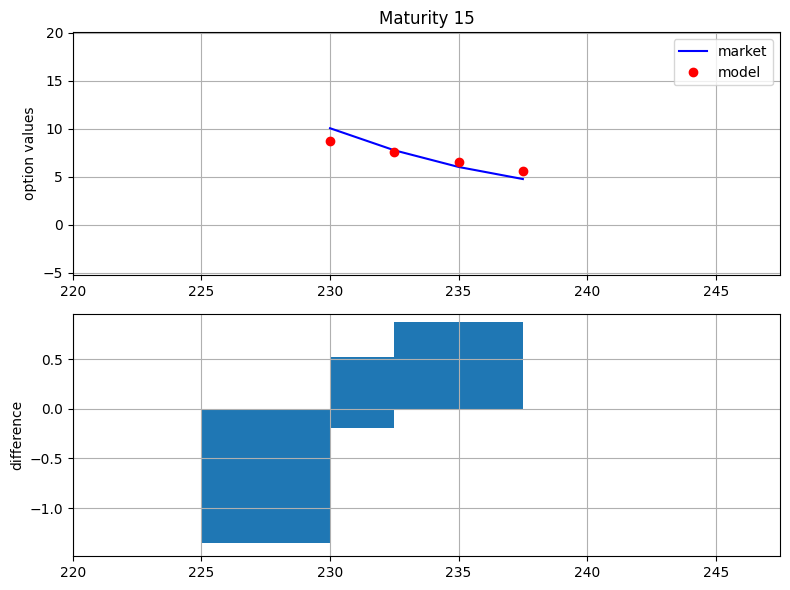

In [ ]:
plot_full_calibration_results(full_params)

## Team Member C

###  Pricing the Asian Option using Monte Carlo Methods

#### Below we price an ATM Asian call option with a 20-day maturity using the calibrated Heston model parameters obtained from Team Member A.

Optimal Parameters: [3.3 ,  0.13,  0. ,   0.67,  0.1 ]

In [ ]:
calibrated_params= optimal_parameters
print(calibrated_params)

[3.29624377e+00 1.29943144e-01 5.45458459e-06 6.68648706e-01
 1.03654781e-01]


In [ ]:
import numpy as np

# Monte Carlo simulation for the Heston model
def simulate_heston(params, S0, T, r, N, M, dt):
    kappa, theta, sigma, rho, v0 = params
    S = np.zeros((N, M))
    V = np.zeros((N, M))
    S[:, 0] = S0
    V[:, 0] = v0

    for t in range(1, M):
        dW1 = np.random.normal(0, np.sqrt(dt), size=N)
        dW2 = np.random.normal(0, np.sqrt(dt), size=N)
        dW2 = rho * dW1 + np.sqrt(1 - rho**2) * dW2

        V[:, t] = V[:, t-1] + kappa * (theta - V[:, t-1]) * dt + sigma * np.sqrt(np.maximum(V[:, t-1], 0)) * dW2
        V[:, t] = np.maximum(V[:, t], 0)  # Ensure variance is non-negative
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * V[:, t-1]) * dt + np.sqrt(np.maximum(V[:, t-1], 0)) * dW1)

    return S

# Parameters for the simulation
T = 20 / 250  # 20 days maturity
r = 0.015
N = 10000  # Number of paths
M = 20  # Number of time steps
dt = T / M  # Time step

# Simulate the stock price paths
np.random.seed(42)  # For reproducibility
calibrated_params = optimal_parameters
stock_paths = simulate_heston(calibrated_params, S0, T, r, N, M, dt)



### Calculating the Payoff of the Asian Call Option

The payoff of the Asian call option is the maximum of the average price of the stock over the period minus the strike price (which is ATM, i.e., S0), or zero.

In [ ]:
# Calculate the average stock price over the period
average_prices = np.mean(stock_paths, axis=1)

# Calculate the payoff of the Asian call option
strike_price = S0  # ATM option
payoff = np.maximum(average_prices - strike_price, 0)

# Discount the payoff to present value
discounted_payoff = np.exp(-r * T) * payoff

# Calculate the fair price of the Asian call option
fair_price = np.mean(discounted_payoff)
print("Fair Price of the Asian Call Option:", fair_price)

Fair Price of the Asian Call Option: 4.754033385608488


### We now calculate the final price including the bank's fee

In [ ]:
# Add the bank's profit margin
final_price = fair_price * 1.04
print("Final Price Charged to the Client:", final_price)


Final Price Charged to the Client: 4.944194721032828


# Step 2

## Team Member A

In [ ]:
# General Parameters
S0 = 232.9
T = 60/250
r = 0.015

# Heston'93 Parameters
kappa_v = 1.5
theta_v = 0.02
sigma_v = 0.15
rho = 0.1
v0 = 0.01

# Merton'76 Parameters
lamb = 0.25
mu = -0.2
delta = 0.1
sigma = np.sqrt(v0)

def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value


def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

def B96_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Lewis (2001) integral value for Bates (1996) characteristic function
    """
    char_func_value = B96_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

def B96_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):

    int_value = quad(
        lambda u: B96_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
        ),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

def B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Call option price in Bates (1996) under FFT
    """

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue


m4_data = pd.DataFrame({
    'Strike': [227.5, 230.0, 232.5, 235.0, 237.5],
    'Days to maturity': [60, 60, 60, 60, 60],
    'Type': ['C', 'C', 'C', 'C', 'C']
})

Call_option = []
for K in m4_data.loc[(m4_data['Days to maturity'] == 60) & (m4_data['Type'] == 'C'), 'Strike'].values:
    option_price = B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
    Call_option.append(option_price)
    print(f"The price of the call option with strike {K} is: {option_price:.4f}")


Calibration process: call option

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import brute, fmin
import matplotlib.pyplot as plt

# Market data (example)
m4_data = pd.DataFrame({
    'Strike': [227.5, 230.0, 232.5, 235.0, 237.5],
    'Days to maturity': [60, 60, 60, 60, 60],
    'Type': ['C', 'C', 'C', 'C', 'C'],
    'Call': [10.5, 9.7, 8.9, 8.2, 7.5]  # example market prices
})

S0 = 232.90  # example spot price
r = 0.015  # constant risk-free rate
T = 60 / 365  # time to maturity in years
options = m4_data.copy()

# Initial parameters for the Bates model
kappa_v = 2.0
theta_v = 0.04
sigma_v = 0.5
rho = -0.7
v0 = 0.04
lamb = 0.1
mu = -0.1
delta = 0.2
p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]

# Bates model characteristic functions
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    c1 = kappa_v * theta_v
    c2 = -np.sqrt((rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2))
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (kappa_v - rho * sigma_v * u * 1j - c2)
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3)))
    H2 = (kappa_v - rho * sigma_v * u * 1j + c2) / sigma_v**2 * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

def M76J_char_func(u, T, lamb, mu, delta):
    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp((1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1)) * T)
    return char_func_value

def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

def B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )
    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j
        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3

    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue

# Calibration Routine
i = 0
min_MSE = 5000.0
local_opt = False

def B96_error_function(p0):
    global i, min_MSE, local_opt, opt1
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0 or v0 < 0.0 or lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    diff = 0.0
    for _, option in options.iterrows():
        model_value = B96_call_FFT(S0, option['Strike'], T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
        diff += (model_value - option['Call'])**2

    MSE = diff / len(options)

    if MSE < min_MSE:
        min_MSE = MSE
        opt1 = p0

    if (i % 50 == 0):
        print("%4d   %9.4f   %s" % (i, MSE, p0))

    i += 1
    return MSE

def B96_calibration_full(p0):
    global i, min_MSE, local_opt, opt1
    i = 0
    min_MSE = 5000.0
    local_opt = False
    opt1 = p0
    opt1 = fmin(B96_error_function, opt1, maxiter=2500, maxfun=4000, xtol=0.0001, ftol=0.0001, disp=True)
    print("Optimum:", opt1)
    print("MSE:", min_MSE)
    return opt1

# Run calibration
params = B96_calibration_full(p0)

def B96_calculate_model_values(p0):
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0
    values = []
    for _, option in options.iterrows():
        model_value = B96_call_FFT(S0, option['Strike'], T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
        values.append(model_value)
    return np.array(values)

def plot_calibration_results(p0):
    options["Model"] = B96_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()
    plt.title("Maturity %s" % str(T))
    plt.ylabel("Option values")
    plt.plot(options.Strike, options.Call, "b", label="Market")
    plt.plot(options.Strike, options.Model, "ro", label="Model")
    plt.legend(loc=0)
    plt.axis([min(options.Strike) - 10, max(options.Strike) + 10, min(options.Call) - 10, max(options.Call) + 10])
    plt.subplot(212)
    plt.grid()
    wi = 5.0
    diffs = options.Model.values - options.Call.values
    plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("Difference")
    plt.axis([min(options.Strike) - 10, max(options.Strike) + 10, min(diffs) * 1.1, max(diffs) * 1.1])
    plt.tight_layout()
    plt.show()

plot_calibration_results(params)


Full calibration process has been performed. The values are  2 (kappa),  0.04 (theta), 0.5 (sigma),  -0.7 (correlation),  0.04, (volatility), 0.1 (lambda), -0.1 (mean reversion speed) and 0.2 (delta).

From the line graph and chart, it shows a good fit of the model.


Put option

In [ ]:
m4_data_put = pd.DataFrame({
    'Strike': [227.5, 230.0, 232.5, 235.0, 237.5],
    'Days to maturity': [60, 60, 60, 60, 60],
    'Type': ['P', 'P', 'P', 'P', 'P']
})

def put_value (S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    call_price = B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
    put_price = call_price - S0 + K * np.exp(-r * T)
    return put_price

put_option = []

for K in m4_data.loc[(m4_data_put['Days to maturity'] == 60) & (m4_data_put['Type'] == 'P'), 'Strike'].values:
    put_price = put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    put_option.append(put_price)
    print(f"The price of the european put option with strike {K} is: {put_price:.4f}")

Calibration process: Put option

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brute, fmin

r= 0.015

# Sample Data
m4_data_put = pd.DataFrame({
    'Strike': [227.5, 230.0, 232.5, 235.0, 237.5],
    'Days to maturity': [60, 60, 60, 60, 60],
    'Type': ['P', 'P', 'P', 'P', 'P'],
    'price': [11.03, 12.15, 13.37, 14.75, 15.62],
    'r': [0.015, 0.015, 0.015, 0.015, 0.015],
})

S0 = 232.9  # Example current price
options_put = m4_data_put.copy()
options_put['Call'] = options_put['price']  # using price column as Call for consistency

def B96_put_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    call_price = B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
    put_price = call_price + K * np.exp(-r * T) - S0
    return put_price

def B96_error_function_put(p0):
    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options_put.iterrows():
        T = option['Days to maturity'] / 365.0
        K = option['Strike']
        r = option['r']
        model_value = B96_put_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
        se.append((model_value - option["price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

def B96_calibration_short_put():
    opt1 = 0.0
    opt1 = brute(
        B96_error_function_put,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )

    opt2 = fmin(
        B96_error_function_put,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=550,
        maxfun=750,
    )
    return opt2

def B96_put_calculate_model_values(p0):
    lamb, mu, delta = p0
    values = []
    for row, option in options_put.iterrows():
        T = option['Days to maturity'] / 365.0
        K = option['Strike']
        r = option['r']
        model_value = B96_put_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
        values.append(model_value)
    return np.array(values)

def plot_calibration_results_put(p0):
    options_put["Model"] = B96_put_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()
    plt.title("Maturity %s" % str(options_put["Days to maturity"].iloc[0]) + " days")
    plt.ylabel("Option Values")
    plt.plot(options_put.Strike, options_put.price, "b", label="Market")
    plt.plot(options_put.Strike, options_put.Model, "ro", label="Model")
    plt.legend(loc=0)
    plt.axis(
        [
            min(options_put.Strike) - 10,
            max(options_put.Strike) + 10,
            min(options_put.price) - 10,
            max(options_put.price) + 10,
        ]
    )
    plt.subplot(212)
    plt.grid()
    wi = 5.0
    diffs = options_put.Model.values - options_put.price.values
    plt.bar(options_put.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("Difference")
    plt.axis(
        [
            min(options_put.Strike) - 10,
            max(options_put.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()
    plt.show()

params_put = B96_calibration_short_put()
plot_calibration_results_put(params_put)


Based on the result, it describes the put option price and prove the model value is fit to the given market value of put option.

## Team Member B

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

In [ ]:
optimal_parameters_B96 = params

In [ ]:
kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = optimal_parameters_B96

#### Stochastic Volatility Simulation

In [ ]:
def SDE_vol(v0, kappa, theta, sigma, T, M, Ite, rand, row, cho_matrix):
    dt = T / M  # T = maturity, M = number of time steps
    v = np.zeros((M + 1, Ite), dtype=float)
    v[0] = v0
    sdt = np.sqrt(dt)  # Sqrt of dt
    for t in range(1, M + 1):
        ran = np.dot(cho_matrix, rand[:, t])
        v[t] = np.maximum(
            0,
            v[t - 1]
            + kappa * (theta - v[t - 1]) * dt
            + np.sqrt(v[t - 1]) * sigma * ran[row] * sdt,
        )
    return v

#### Heston Paths

In [ ]:
def Heston_paths(S0, r, v, row, cho_matrix):
    S = np.zeros((M + 1, Ite), dtype=float)
    S[0] = S0
    sdt = np.sqrt(dt)
    for t in range(1, M + 1, 1):
        ran = np.dot(cho_matrix, rand[:, t])
        S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt + np.sqrt(v[t]) * ran[row] * sdt)

    return S

In [ ]:
def random_number_gen(M, Ite):
    rand = np.random.standard_normal((2, M + 1, Ite))
    return rand

These are the parameters resulting from calibration of the Heston (1993) model:

- $\kappa_\nu = 3.2962$
- $\theta_\nu = 0.1299$
- $\sigma_\nu = 0.00$
- $\rho = 0.6686$
- $\nu_0 = 0.1037$

\




In [ ]:
kappa_v = 3.2961
theta_v = 0.1299
sigma_v = 0.00
rho = 0.6686
v0 = 0.1037

S0 = 232.9  # Current underlying asset price
r = 0.015  # Risk-free rate
M0 = 50  # Number of time steps in a year
T = 70/250  # Number of years
M = int(M0 * T)  # Total time steps
Ite = 10000  # Number of simulations
dt = T / M  # Length of time step

In [ ]:
# Generating random numbers from standard normal
rand = random_number_gen(M, Ite)


# Covariance Matrix
covariance_matrix = np.zeros((2, 2), dtype=float)
covariance_matrix[0] = [1.0, rho]
covariance_matrix[1] = [rho, 1.0]
cho_matrix = np.linalg.cholesky(covariance_matrix)

In [ ]:
# Volatility process paths
V = SDE_vol(v0, kappa_v, theta_v, sigma_v, T, M, Ite, rand, 1, cho_matrix)

# Underlying price process paths
S = Heston_paths(S0, r, V, 0, cho_matrix)

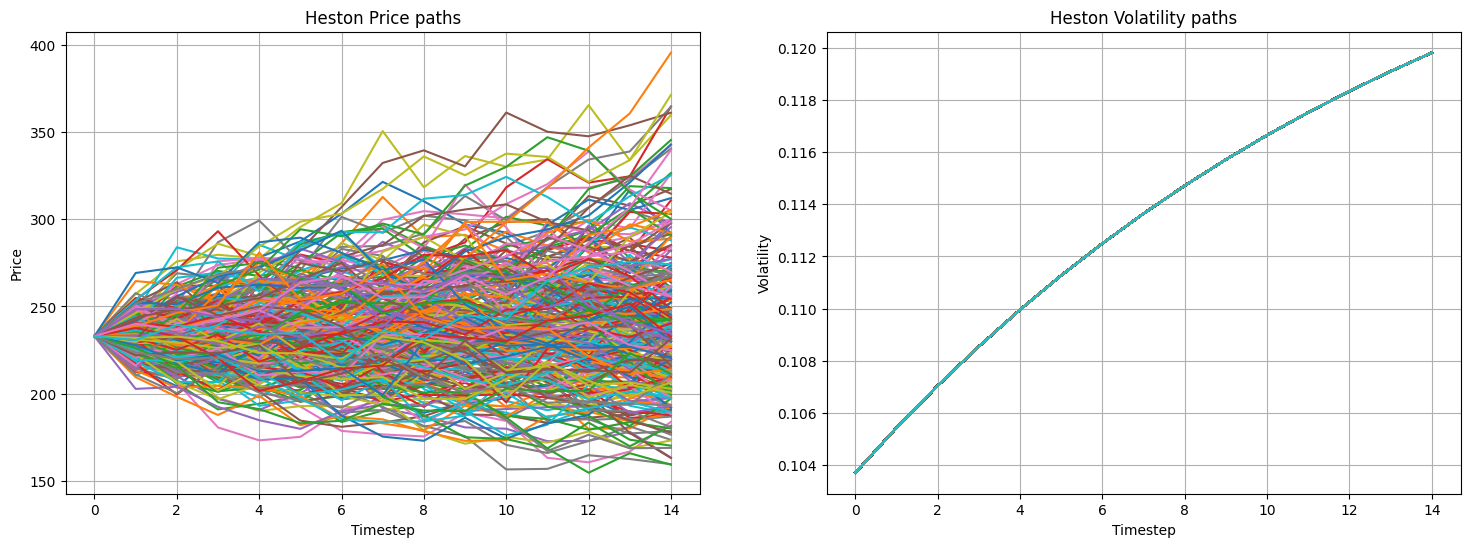

In [ ]:
def plot_paths(n):
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.plot(range(len(S)), S[:, :n])
    ax1.grid()
    ax1.set_title("Heston Price paths")
    ax1.set_ylabel("Price")
    ax1.set_xlabel("Timestep")

    ax2.plot(range(len(V)), V[:, :n])
    ax2.grid()
    ax2.set_title("Heston Volatility paths")
    ax2.set_ylabel("Volatility")
    ax2.set_xlabel("Timestep")


plot_paths(300)

In [ ]:
def heston_call_mc(S, K, r, T, t):
    payoff = np.maximum(0, S[-1, :] - K)

    average = np.mean(payoff)

    return np.exp(-r * (T - t)) * average

In [ ]:
K = S0*0.95
call_price = heston_call_mc(S, K, r, T, 0)
print("European Call Price under Heston: ", call_price)

European Call Price under Heston:  23.32037634672549


In [ ]:
put_price = call_price + K * np.exp(-r * T) - S0
print(f"European Put Option Price under Heston: {put_price}")

European Put Option Price under Heston: 10.748054086634966


In [ ]:
# Put-Call Parity
round(call_price + K * np.exp(-r * T), 2) == round(S0 + put_price, 2)

True

In [ ]:
final_put_price = put_price * 1.04
print(f"Put Option Price (Heston 1993): ${round(final_put_price,2)}")

Put Option Price (Heston 1993): $11.18


#### Final Price For Asian Put

In [ ]:
# Calculate the average stock price over the period
average_prices = np.mean(S, axis=1)

# Calculate the payoff of the Asian Put option
strike_price = K
payoff = np.maximum(strike_price - average_prices, 0)

# Discount the payoff to present value
discounted_payoff = np.exp(-r * T) * payoff

# Calculate the fair price of the Asian Put option
fair_price = np.mean(discounted_payoff)
print("Fair Price of the Asian Put Option:", fair_price)

Fair Price of the Asian Put Option: 0.0


## Team Member C

 ## Calibrate Heston (1993) stochastic volatility model

## Obtaining the calibrated parameters from the calibration of Heston

In [ ]:
kappa_v, theta_v, sigma_v, rho, v0 = calibrated_params

In [ ]:
print("Optimal Parameters: kappa_v = {:.4f}, theta_v = {:.4f}, sigma_v = {:.4f}, rho = {:.4f}, v0 = {:.4f}".format(*optimal_parameters))


Optimal Parameters: kappa_v = 3.2962, theta_v = 0.1299, sigma_v = 0.0000, rho = 0.6686, v0 = 0.1037


These are the parameters resulting from calibration of the Heston (1993) model:

- $\kappa_\nu = 3.2962$
- $\theta_\nu = 0.1299$
- $\sigma_\nu = 0.00$
- $\rho = 0.6686$
- $\nu_0 = 0.1037$

\
We now make use of these parameters to calibrate the jump component of the model.



## Getting options market data

In [ ]:
sheet_id = "1cfYZ9Y9yK99-Mu9Yd-f7PxAbzhAaK0BxFPSgtCKdYKs"


# Construct the URL for downloading CSV from Google Sheets
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv"

# Read the CSV data into a pandas DataFrame
data = pd.read_csv(url)
data = pd.DataFrame(data)


print(data.head())
S0 = 232.9

   Days to maturity  Strike  Price Type
0                15   227.5  10.52    C
1                15   230.0  10.05    C
2                15   232.5   7.75    C
3                15   235.0   6.01    C
4                15   237.5   4.75    C


Next, we now select the options near ATM we are going to take into account in our calibration procedures

In [ ]:
S0 = 232.9  # Current stock price
tol = 0.02  # Tolerance level to select ATM options (percent around ITM/OTM options)

# Select ATM options within tolerance
atm_options = data[(np.abs(data["Strike"] - S0) / S0) < tol]
print("ATM Options:\n", atm_options)

# Filter for 'Call' options with 60 days to maturity
call_options = atm_options[(atm_options['Type'] == 'C') & (atm_options['Days to maturity'] == 60)]
print("Call Options:\n", call_options)

# Check if the resulting DataFrame is empty
if call_options.empty:
    print("No Call options within the specified tolerance and maturity date.")
else:
    # Use call_options DataFrame for further calculations
    market_prices = call_options['Price']
    strikes = call_options['Strike']
    maturities = call_options['Days to maturity']

    # Calculate Time-to-Maturity (T) and add a constant short-rate (r)
    call_options["T"] = call_options['Days to maturity'] / 250  # Assuming 250 trading days in a year
    call_options["r"] = 0.015

    print("Processed Call Options:\n", call_options)


ATM Options:
     Days to maturity  Strike  Price Type
1                 15   230.0  10.05    C
2                 15   232.5   7.75    C
3                 15   235.0   6.01    C
4                 15   237.5   4.75    C
6                 60   230.0  17.65    C
7                 60   232.5  16.86    C
8                 60   235.0  16.05    C
9                 60   237.5  15.10    C
11               120   230.0  24.12    C
12               120   232.5  22.97    C
13               120   235.0  21.75    C
14               120   237.5  18.06    C
16                15   230.0   5.20    P
17                15   232.5   6.45    P
18                15   235.0   7.56    P
19                15   237.5   8.78    P
21                60   230.0  12.15    P
22                60   232.5  13.37    P
23                60   235.0  14.75    P
24                60   237.5  15.62    P
26               120   230.0  16.25    P
27               120   232.5  17.22    P
28               120   235.0  18.74    P
29

## Calibration of the jump component

Define the Bates Model Parameters and Functions

In [ ]:
i = 0
min_MSE = 5000.0
local_opt = False

In [ ]:
def B96_error_function(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0

    se = []
    for _, option in call_options.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)

    global i, min_MSE, local_opt, opt1
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE



##  We now define the different characteristic functions and computation of the Lewis (2001) integral

In [ ]:
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

In [ ]:
def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

In [ ]:
def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

In [ ]:
def B96_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Lewis (2001) integral value for Bates (1996) characteristic function
    """
    char_func_value = B96_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

##  Define the Option pricing functions

In [ ]:



    def B96_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
        """
        Valuation of European call option in B96 Model via Lewis (2001)
        Parameters:
        ==========
        S0: float
            initial stock/index level
        K: float
            strike price
        T: float
            time-to-maturity (for t=0)
        r: float
            constant risk-free short rate
        kappa_v: float
            mean-reversion factor
        theta_v: float
            long-run mean of variance
        sigma_v: float
            volatility of variance
        rho: float
            correlation between variance and stock/index level
        v0: float
            initial level of variance
        lamb: float
            jump intensity
        mu: float
            expected jump size
        delta: float
            standard deviation of jump
        ==========
        """
        int_value = quad(
            lambda u: B96_int_func(
                u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            ),
            0,
            np.inf,
            limit=250,
        )[0]
        call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
        return call_value



##  we can create our functions to calibrate the jump component of the model:

In [ ]:
def B96_calibration_short():
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        B96_error_function,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_error_function,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=550,
        maxfun=750,
    )
    return opt2

In [ ]:
# Run the calibration
optimal_params = B96_calibration_short()
print("Optimal Parameters:", np.round(optimal_params, 5))



   0 | [ 0.  -0.5  0. ] |   1.520 |   1.520
  25 | [ 0.2  -0.5   0.25] |   0.348 |   0.229
  50 | [ 0.4 -0.5  0.5] |   6.445 |   0.157
  75 | [ 5.0e-01 -2.0e-01  2.5e-04] |   0.156 |   0.148
 100 | [ 0.60650843 -0.18688854  0.00073448] |   0.146 |   0.146
 125 | [ 0.85760998 -0.15299058  0.0020598 ] |   0.143 |   0.143
 150 | [ 1.22197784 -0.12745413  0.00295811] |   0.140 |   0.140
 175 | [ 1.51155073 -0.1140194   0.00311425] |   0.138 |   0.138
 200 | [ 1.95223576 -0.09852411  0.00322294] |   0.138 |   0.137
 225 | [ 2.51519495 -0.08679428  0.00280811] |   0.136 |   0.136
 250 | [ 3.22747700e+00 -7.69615791e-02  2.15660999e-03] |   0.135 |   0.135
 275 | [ 3.92210120e+00 -6.95882828e-02  1.37260302e-03] |   0.134 |   0.134
 300 | [ 4.89229625e+00 -6.20626138e-02  1.64524903e-06] |   0.133 |   0.133
 325 | [ 4.90867538e+00 -6.18555782e-02  8.70759794e-07] |   0.133 |   0.133
 350 | [ 4.91092233e+00 -6.18301960e-02  9.34832197e-10] |   0.133 |   0.133
 375 | [ 4.91079101e+00 -6.1831886

### calibrating the jump component yields:

lamb = 58.705

mu = -0.0169

delta = 0.00482

In [ ]:
lamb = 58.705

mu = -0.0169

delta = 0.00482

### Model vs. Market prices after jump calibration

We Now observe how our model prices fit the observed market prices after this 2 step calibration process.

\
For that, we first create a function that yields the model values under the different parameters obtained in the calibration process:

In [ ]:
def B96_jump_calculate_model_values(p0):
    """Calculates all model values given parameter vector p0."""
    if len(p0) < 3:
        raise ValueError("Parameter vector p0 must contain at least three values: lamb, mu, and delta")

    lamb, mu, delta = p0[:3]
    values = []
    for _, option in call_options.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        values.append(model_value)
    return np.array(values)


In [ ]:
def plot_calibration_results(p0):
    call_options["Model"] = B96_jump_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))

    # First subplot: market vs model option values
    plt.subplot(211)
    plt.grid()
    plt.title("Maturity %s" % str(call_options["Days to maturity"].iloc[0])[:10])
    plt.ylabel("Option Values")
    plt.plot(call_options.Strike, call_options.Price, "b", label="Market")
    plt.plot(call_options.Strike, call_options.Model, "ro", label="Model")
    plt.legend(loc=0)
    plt.axis(
        [
            min(call_options.Strike) - 10,
            max(call_options.Strike) + 10,
            min(call_options.Price) - 10,
            max(call_options.Price) + 10,
        ]
    )

    # Second subplot: difference between market and model values
    plt.subplot(212)
    plt.grid()
    wi = 5.0
    diffs = call_options.Model.values - call_options.Price.values
    plt.bar(call_options.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("Difference")
    plt.axis(
        [
            min(call_options.Strike) - 10,
            max(call_options.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )

    plt.tight_layout()
    plt.show()


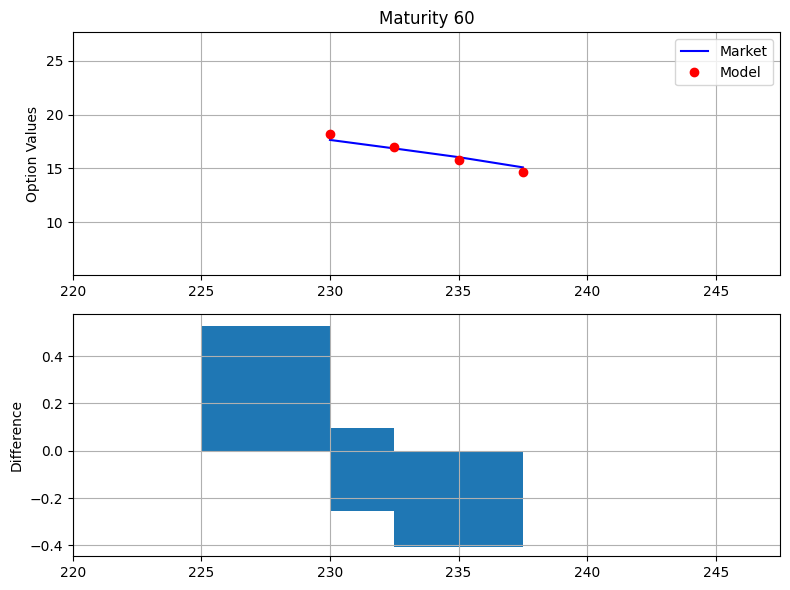

In [ ]:
params = [58.705,  -0.0169, 0.00482]

plot_calibration_results(params)


##  Full Bates (1996) model calibration

In [ ]:
p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]

In [ ]:
i = 0
min_MSE = 5000.0

In [ ]:
def B96_full_error_function(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0[:8]

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    call_options_filtered = call_options[call_options["Type"] == "C"]
    for _, option in call_options_filtered.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Price"]) ** 2)  # Updated to "Price"

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE


In [ ]:
def B96_calibration_full():
    opt = fmin(
        B96_full_error_function, p0, xtol=0.001, ftol=0.001, maxiter=1250, maxfun=650
    )
    return opt


In [ ]:
def B96_calculate_model_values(p0):
    """Calculates all model values given parameter vector p0."""
    if len(p0) < 8:
        raise ValueError("Parameter vector p0 must contain at least eight values: kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, and delta")

    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0[:8]
    values = []
    call_options_filtered = call_options[call_options["Type"] == "C"]
    for _, option in call_options_filtered.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        values.append(model_value)
    return np.array(values)


In [ ]:

# Perform calibration
full_params = B96_calibration_full()

# Print the values of the full parameters to 5 decimal places
formatted_params = [f"{param:.5f}" for param in full_params]
print("Full parameters to 5 decimal places:", formatted_params)


   0 | [ 3.29624377e+00  1.29943144e-01  5.45458459e-06  6.68648706e-01
  1.03654781e-01  5.87050000e+01 -1.69000000e-02  4.82000000e-03] |   0.129 |   0.129
  25 | [ 3.32271520e+00  1.31252674e-01  5.49838919e-06  6.74018482e-01
  1.04048255e-01  5.86556483e+01 -1.68461400e-02  4.85870839e-03] |   0.129 |   0.129
  50 | [ 3.33775406e+00  1.29839772e-01  5.51175065e-06  6.75834560e-01
  1.03844040e-01  5.87253676e+01 -1.69023950e-02  4.84151323e-03] |   0.129 |   0.129
  75 | [ 3.83150787e+00  1.30581888e-01  5.75981114e-06  7.38757685e-01
  1.05548686e-01  5.64841430e+01 -1.64583620e-02  3.31546662e-03] |   0.128 |   0.128
 100 | [ 4.69140027e+00  1.29646241e-01  5.76687357e-06  8.78376171e-01
  1.08982541e-01  5.11932877e+01 -1.57041691e-02  1.07901210e-03] |   0.128 |   0.128
 125 | [ 5.01089960e+00  1.29818681e-01  5.81430397e-06  9.42863601e-01
  1.10727769e-01  4.85192851e+01 -1.52417985e-02  3.62304525e-04] |   0.128 |   0.128
 150 | [ 5.32203533e+00  1.31418128e-01  5.37353772e

The results of the full calibration are :

- $\kappa_\nu = 5.57919$
- $\theta_\nu = 0.12016$
- $\sigma_\nu = 0.00001$
- $\rho = 0.93145$
- $\nu_0 = 0.13784$
- $\lambda = 0.014$
- $\mu = -0.01049$
- $\delta = 0.00001$




In [ ]:

def plot_calibration_results(p0):
    call_options_filtered = call_options[call_options["Type"] == "C"]
    call_options_filtered["Model"] = B96_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()
    plt.title("Maturity: 60 days")
    plt.ylabel("Option Values")
    plt.plot(call_options_filtered.Strike, call_options_filtered.Price, "b", label="Market")
    plt.plot(call_options_filtered.Strike, call_options_filtered.Model, "ro", label="Model")
    plt.legend(loc=0)
    plt.axis(
        [
            min(call_options_filtered.Strike) - 10,
            max(call_options_filtered.Strike) + 10,
            min(call_options_filtered.Price) - 10,
            max(call_options_filtered.Price) + 10,
        ]
    )
    plt.subplot(212)
    plt.grid()
    wi = 5.0
    diffs = call_options_filtered.Model.values - call_options_filtered.Price.values
    plt.bar(call_options_filtered.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("Difference")
    plt.axis(
        [
            min(call_options_filtered.Strike) - 10,
            max(call_options_filtered.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()
    plt.show()






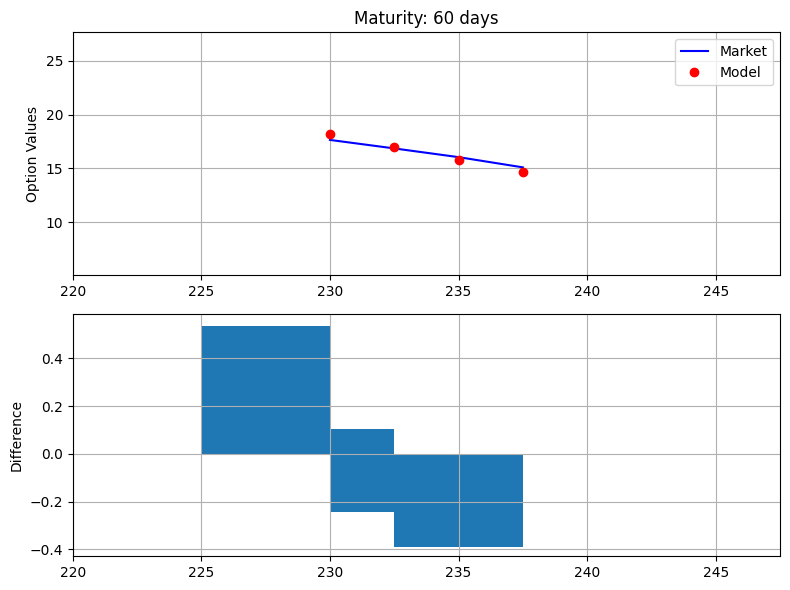

In [ ]:
# Plot results
plot_calibration_results(full_params)

# Step 3

Question a

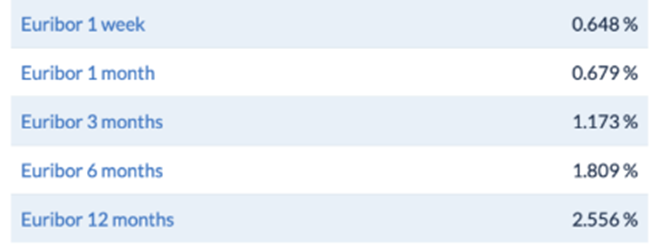

Given Euribor rates with varies maturity period that important in risk-neutral valuation. The model of Cox-Ingersoll-ross (CIR) is used for bond valuation. The formula of CIR is described as below:

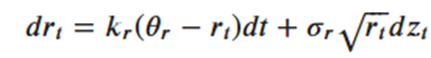

The price of zero-coupon bond is calculated by:

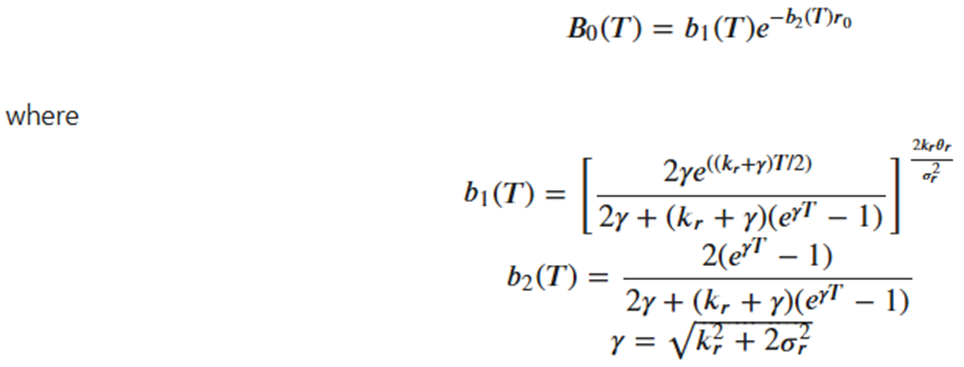


Afterward is calculating forward and capitalization factors where selecting four model parameters which are kappa, theta, sigma, and risk-free rates.

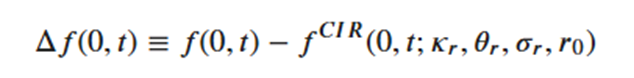

Forward is calculated as below:

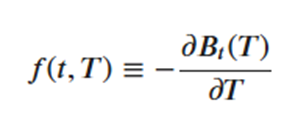

The formula of CIR (1985) defines as below where forward rate is locate between t and T with a set of parameters of a:


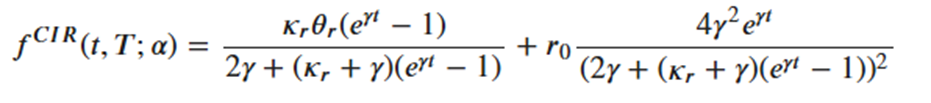


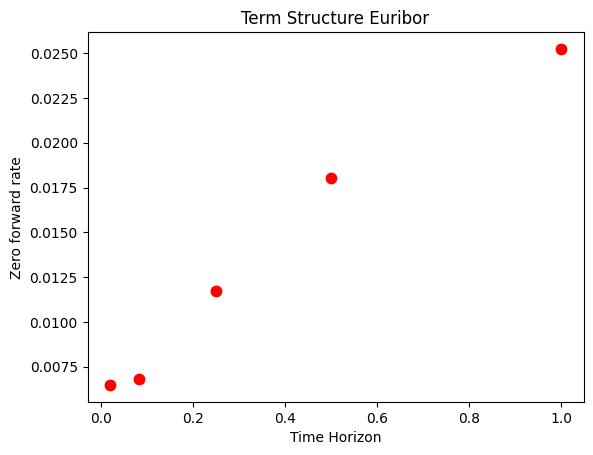

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

mat_list = np.array((7, 30, 90, 180, 360)) / 360
rate_list = (
    np.array((0.648, 0.679, 1.173, 1.809, 2.556)) / 100
)
r0 = rate_list[0]
factors = 1 + mat_list * rate_list
zero_rates = 1 / mat_list * np.log(factors)

plt.plot(mat_list, zero_rates, "r.", markersize="15")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.show()

The plot of forward rates are showed at above.

Interpolation of Market Rates

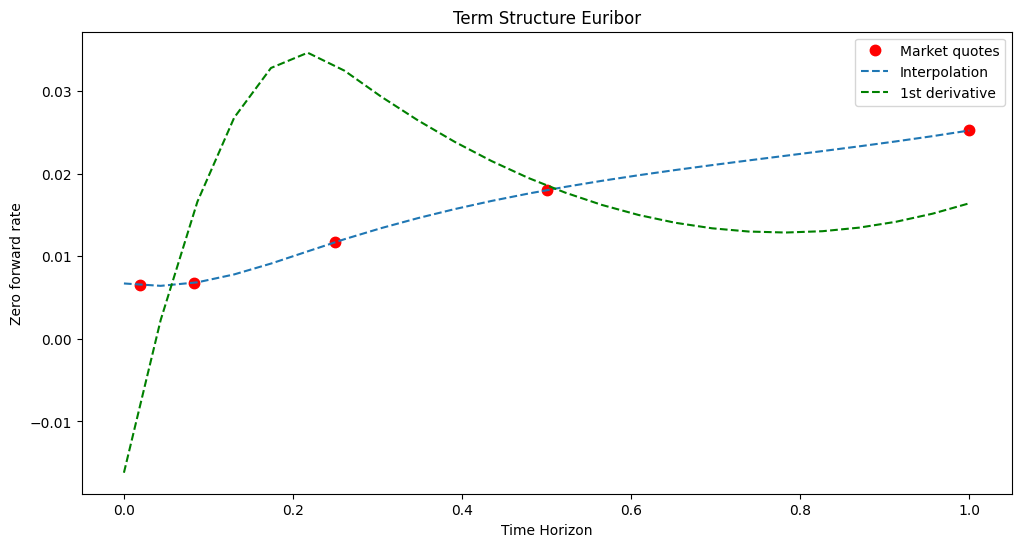

In [ ]:
from scipy.interpolate import splev, splrep

bspline = splrep(mat_list, zero_rates, k=3)  # Cubic spline
mat_list_n = np.linspace(
    0.0, 1.0, 24
)  # Create 24 equally spaced maturities between 0 and 1
inter_rates = splev(mat_list_n, bspline, der=0)  # Interpolated rates

first_der = splev(mat_list_n, bspline, der=1)  # First derivative of spline
f = (
    inter_rates + first_der * mat_list_n
)  # Forward rate given interpolated ones and first derivative

plt.figure(figsize=(12, 6))
plt.plot(mat_list, zero_rates, "r.", markersize="15", label="Market quotes")
plt.plot(mat_list_n, inter_rates, "--", markersize="10", label="Interpolation")
plt.plot(mat_list_n, first_der, "g--", markersize="10", label="1st derivative")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.legend()
plt.show()

From this line graph, the market quotes and interpolation data do not fit enough. Thus, it should include more data to calibrate with the interest rate model.

Forward Rate

In [ ]:
def CIR_forward_rate(alpha):
    """
    Forward rates in CIR (1985) model
    The set of parameters is called alpha and include Kappa_r, Theta_r and Sigma_r
    """

    kappa_r, theta_r, sigma_r = alpha

    t = mat_list_n
    g = np.sqrt(kappa_r**2 + 2 * sigma_r**2)

    s1 = (kappa_r * theta_r * (np.exp(g * t) - 1)) / (
        2 * g + (kappa_r + g) * (np.exp(g * t) - 1)
    )

    s2 = r0 * (
        (4 * g**2 * np.exp(g * t)) / (2 * g + (kappa_r + g) * (np.exp(g * t)) ** 2)
    )

    return s1 + s2

Error Function¶

In [ ]:
def CIR_error_function(alpha):
    """
    Error function to calibrate CIR (1985) model
    """

    kappa_r, theta_r, sigma_r = alpha

    # Few remarks to avoid problems for certain values of parameters:
    if 2 * kappa_r * theta_r < sigma_r**2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100

    forward_rates = CIR_forward_rate(alpha)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)

    return MSE

In order to avoid overfit or underfit issue, mean squared error (MSE) is adopted during the calibration process. The formula is showed as below:



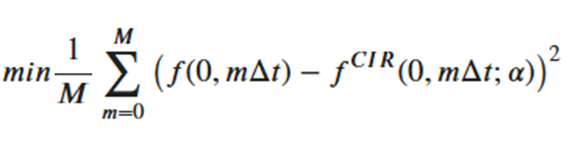

Optimization

In [ ]:
from scipy.optimize import fmin

def CIR_calibration():
    opt = fmin(
        CIR_error_function,
        [1.0, 0.02, 0.1],
        xtol=0.00001,
        ftol=0.00001,
        maxiter=300,
        maxfun=500,
    )

    return opt

The function CIT_calibration is created to optimize and minimize the difference between model and market rates.

Results

In [ ]:
params = CIR_calibration()
params

Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 161
         Function evaluations: 288


array([0.98908305, 0.10863186, 0.00100074])

The value of kappa is 0.98908305, theta defined as 0.10863186, and sigma equal to 0.00100074.

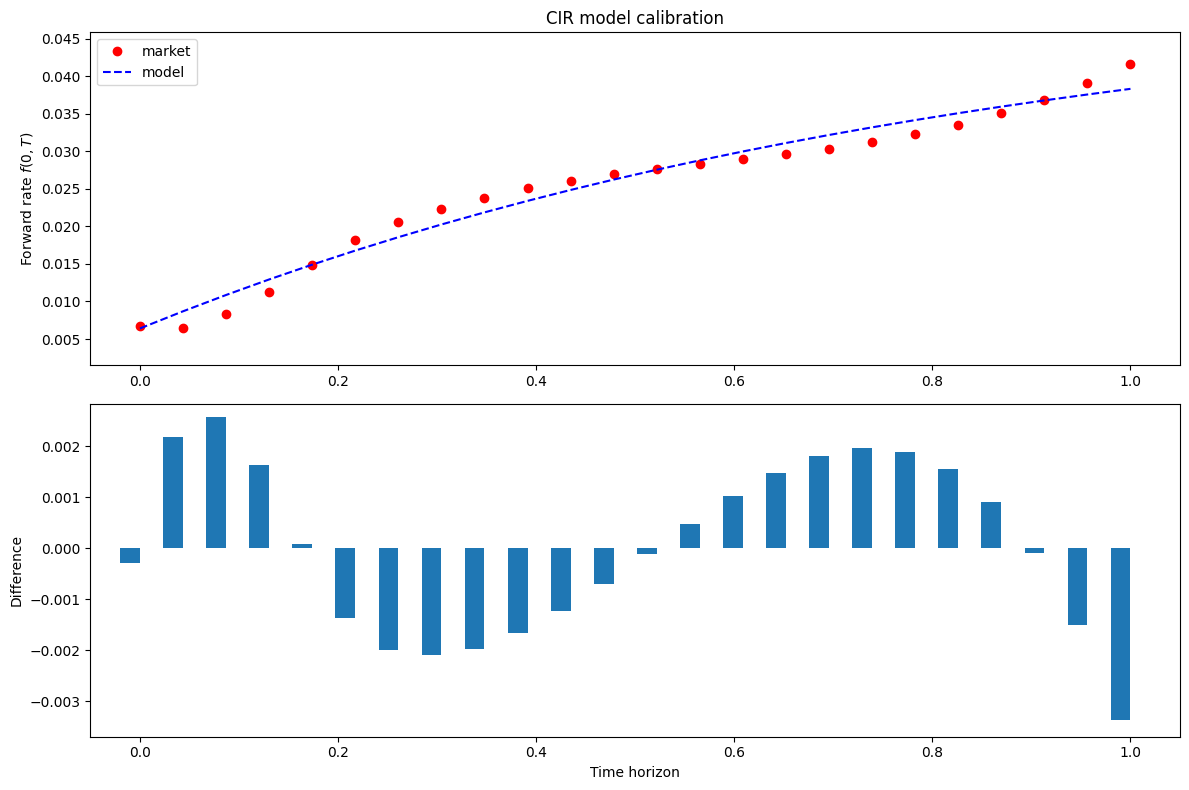

In [ ]:


def plot_calibrated_frc(opt):
    """Plots market and calibrated forward rate curves."""
    forward_rates = CIR_forward_rate(opt)
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plt.title("CIR model calibration")
    plt.ylabel("Forward rate $f(0,T)$")
    plt.plot(mat_list_n, f, "ro", label="market")
    plt.plot(mat_list_n, forward_rates, "b--", label="model")
    plt.legend(loc=0)
    plt.axis(
        [min(mat_list_n) - 0.05, max(mat_list_n) + 0.05, min(f) - 0.005, max(f) * 1.1]
    )
    plt.subplot(212)
    wi = 0.02
    plt.bar(mat_list_n - wi / 2, forward_rates - f, width=wi)
    plt.xlabel("Time horizon")
    plt.ylabel("Difference")
    plt.axis(
        [
            min(mat_list_n) - 0.05,
            max(mat_list_n) + 0.05,
            min(forward_rates - f) * 1.1,
            max(forward_rates - f) * 1.1,
        ]
    )
    plt.tight_layout()

plot_calibrated_frc(params)

Referred to the CIR model calibration, it can see the market quotes and model is greatly fit compared to initial model.

Question b

## 	For the given the different CIR model parameters obtained in the previous step, below we simulate Euribor 12-month rates daily for a period of 1 year.


### Defining the function for the simulation

In [ ]:
# CIR model parameters
kappa = 0.9891 # speed of reversion
theta = 0.1086# long-term mean level
sigma = 0.001# volatility
r0 = 2.556/100  # Euribor 12 Months rate
T = 1  # time in years
dt = 1 / 250  # daily time step : Assumming 1 year has 250 trading days.
n_simulations = 100000  # number of Monte Carlo simulations

# Simulate the CIR process
def simulate_CIR(kappa, theta, sigma, r0, T, dt, n_simulations):
    n_steps = int(T / dt)
    rates = np.zeros((n_simulations, n_steps))
    rates[:, 0] = r0
    for t in range(1, n_steps):
        z = np.random.standard_normal(n_simulations)
        dr = kappa * (theta - rates[:, t-1]) * dt + sigma * np.sqrt(rates[:, t-1] * dt) * z
        rates[:, t] = np.maximum(rates[:, t-1] + dr, 0)  # ensure rates stay positive
    return rates

### We now Extract the final 12-month Euribor rates using the above defined function

In [ ]:
# Perform the simulation
rates = simulate_CIR(kappa, theta, sigma, r0, T, dt, n_simulations)

# Extract the final 12-month Euribor rates
final_rates = rates[:, -1]

# Print the final rates
# Print the last simulated 12-month Euribor rate
print("Last 12-month Euribor rate after simulation:")
print(final_rates[-1])

Last 12-month Euribor rate after simulation:
0.07766028173890642


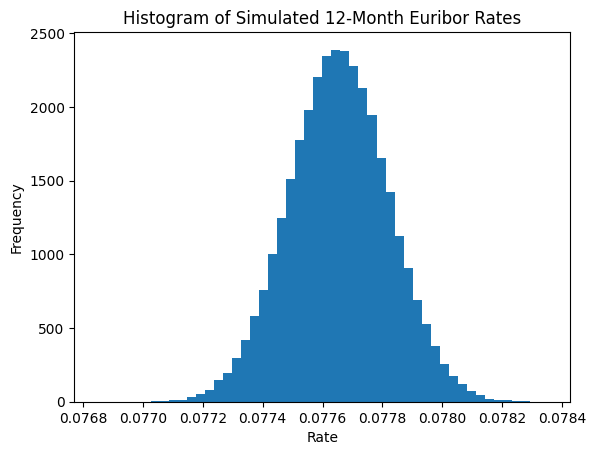

In [ ]:
# Plot the histogram of the final rates
plt.hist(final_rates, bins=50, density=True)
plt.title('Histogram of Simulated 12-Month Euribor Rates')
plt.xlabel('Rate')
plt.ylabel('Frequency')
plt.show()




# i. Confidence Interval calculation

In [ ]:
# Calculate the confidence interval
confidence_interval = np.percentile(final_rates, [2.5, 97.5])
print("Confidence Interval (95%):")
print("Minimum rate:", confidence_interval[0])
print("Maximum rate:", confidence_interval[1])


Confidence Interval (95%):
Minimum rate: 0.07732789804983531
Maximum rate: 0.07798067347640605


# ii. Expected Value computation


In [ ]:
# Calculate the expected value
expected_value = np.mean(final_rates)
print("Expected Value of the 12-month Euribor in 1 year:", expected_value)

Expected Value of the 12-month Euribor in 1 year: 0.07765436914120588



# iii. Discussing the impact on pricing products

In [ ]:
current_rate = r0
print(f"Current 12-month Euribor rate: {current_rate:.4f}")
print(f"Difference between expected and current rate: {expected_value - current_rate:.4f}")

if expected_value > current_rate:
    print("The expected increase in the Euribor rate suggests that borrowing costs will rise, potentially increasing the cost of products linked to this rate.")
else:
    print("The expected decrease in the Euribor rate suggests that borrowing costs will decrease, potentially lowering the cost of products linked to this rate.")


Current 12-month Euribor rate: 0.0256
Difference between expected and current rate: 0.0521
The expected increase in the Euribor rate suggests that borrowing costs will rise, potentially increasing the cost of products linked to this rate.


In [ ]:
count = 0

while count < 5:
    print(count)
    count += 1

0
1
2
3
4
